In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.distribution_analysis.process_tree import get_observed_nodes

import seaborn as sns
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df
from src.datasets.load_trees import load_trees, TreeDataset
from src.utils.tree_utils import get_taxa_names

In [38]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [64]:
DATA_SET = TreeDataset.YULE_10
DATA_SET_NAME = DATA_SET.value

### Load trees

In [65]:
trees = load_trees(DATA_SET, max_trees=50_000)

2it [00:23, 11.75s/it]


In [66]:
taxa_names = get_taxa_names(trees[0])
observed_nodes, observed_clade_splits = get_observed_nodes(trees, taxa_names)
df_clade_splits = get_clade_split_df(observed_clade_splits)

50000it [00:01, 35320.84it/s]
100%|██████████| 450000/450000 [00:00<00:00, 1366206.98it/s]


In [67]:
len(observed_clade_splits)

450000

### Analyze clade split heights

In [68]:
df_clade_splits["height"].describe()

count    450000.000000
mean          0.035666
std           0.026340
min           0.000000
25%           0.014637
50%           0.029025
75%           0.058931
max           0.140743
Name: height, dtype: float64

In [69]:
%%script true

grid = sns.FacetGrid(df_clade_splits, col="clade_split", col_wrap=8, height=2)
grid.map(sns.histplot, "height", kde=True, stat="density")

### Analyze observed branch lengths

In [70]:
df_clade_splits["min_branch"].describe()

count    4.500000e+05
mean     9.382304e-03
std      1.025787e-02
min      1.154600e-08
25%      2.975078e-03
50%      6.029282e-03
75%      1.134311e-02
max      1.119977e-01
Name: min_branch, dtype: float64

<Axes: xlabel='left_branch', ylabel='right_branch'>

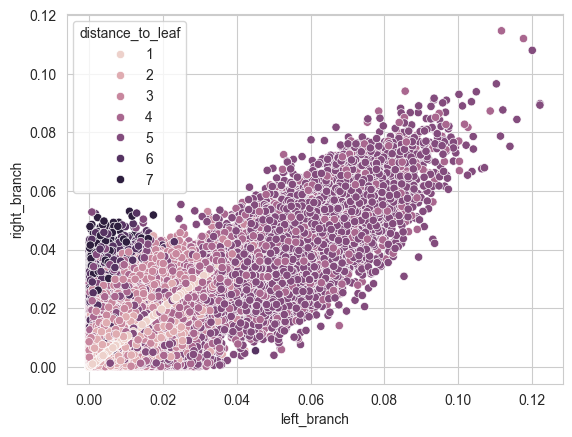

In [71]:
sns.scatterplot(data=df_clade_splits, x="left_branch", y="right_branch", hue="distance_to_leaf")

### Analyze branch lengths per clade split

Text(0.5, 1.0, 'Branch length correlation by distance to leaf (Yule-10)')

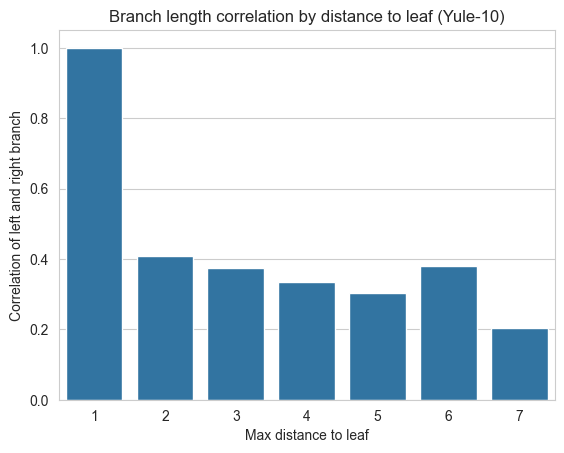

In [82]:
avg_correlation_per_level = df_clade_splits.groupby("distance_to_leaf").apply(
    lambda y: y.groupby("clade_split")
    .apply(lambda x: x["left_branch"].corr(y["right_branch"]))
    .mean()
)
sns.barplot(data=avg_correlation_per_level)

plt.ylabel("Correlation of left and right branch")
plt.xlabel("Max distance to leaf")

plt.title(f"Branch length correlation by distance to leaf ({DATA_SET_NAME})")

In [76]:
import pandas as pd
from tqdm import tqdm

from src.distribution_analysis.clade import ObservedCladeSplit


df_dict = {
    "clade_split": [],
    "min_branch_0": [],
    "min_branch_1": [],
    "min_branch_2": [],
    "min_branch_l": [],
    "min_branch_r": [],
}

for clade_split in tqdm(observed_clade_splits):
    min_branch_0 = clade_split.min_branch_length

    min_branch_1 = None
    min_branch_2 = None
    min_branch_l = None
    min_branch_r = None

    if isinstance(clade_split.min_branch_clade, ObservedCladeSplit):
        min_branch_1 = clade_split.min_branch_clade.min_branch_length

        if isinstance(clade_split.min_branch_clade.min_branch_clade, ObservedCladeSplit):
            min_branch_2 = clade_split.min_branch_clade.min_branch_clade.min_branch_length

    if isinstance(clade_split.left_clade, ObservedCladeSplit):
        min_branch_l = clade_split.left_clade.min_branch_length
    
    if isinstance(clade_split.right_clade, ObservedCladeSplit):
        min_branch_r = clade_split.right_clade.min_branch_length

    df_dict["clade_split"].append(clade_split.bitstring)
    df_dict["min_branch_0"].append(min_branch_0)
    df_dict["min_branch_1"].append(min_branch_1)
    df_dict["min_branch_2"].append(min_branch_2)
    df_dict["min_branch_l"].append(min_branch_l)
    df_dict["min_branch_r"].append(min_branch_r)

df_extended_branches = pd.DataFrame(df_dict)

100%|██████████| 450000/450000 [00:00<00:00, 680937.23it/s]


<Axes: >

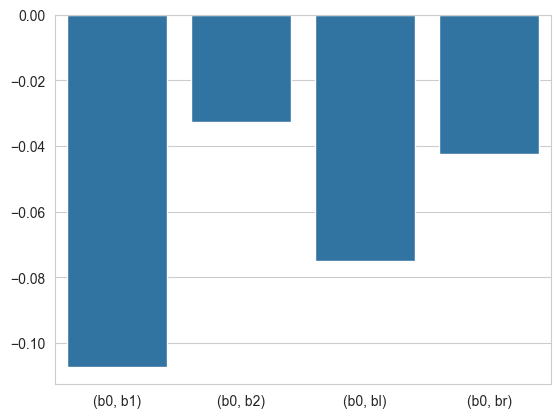

In [83]:
sns.barplot(
    x=["(b0, b1)", "(b0, b2)", "(b0, bl)", "(b0, br)"],
    y=[
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].corr(df_extended_branches["min_branch_1"]))
        .mean(),
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].corr(df_extended_branches["min_branch_2"]))
        .mean(),
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].corr(df_extended_branches["min_branch_l"]))
        .mean(),
        df_extended_branches.groupby("clade_split")
        .apply(lambda x: x["min_branch_0"].corr(df_extended_branches["min_branch_r"]))
        .mean(),
    ],
)

### Min branch length distributions

In [75]:
df_most_common_branches_splits = df_clade_splits[df_clade_splits.clade_split.isin(df_clade_splits.clade_split.value_counts().nlargest(16).index)]

Text(0.5, 0.98, 'Distribution of d_min per clade split (DS4)')

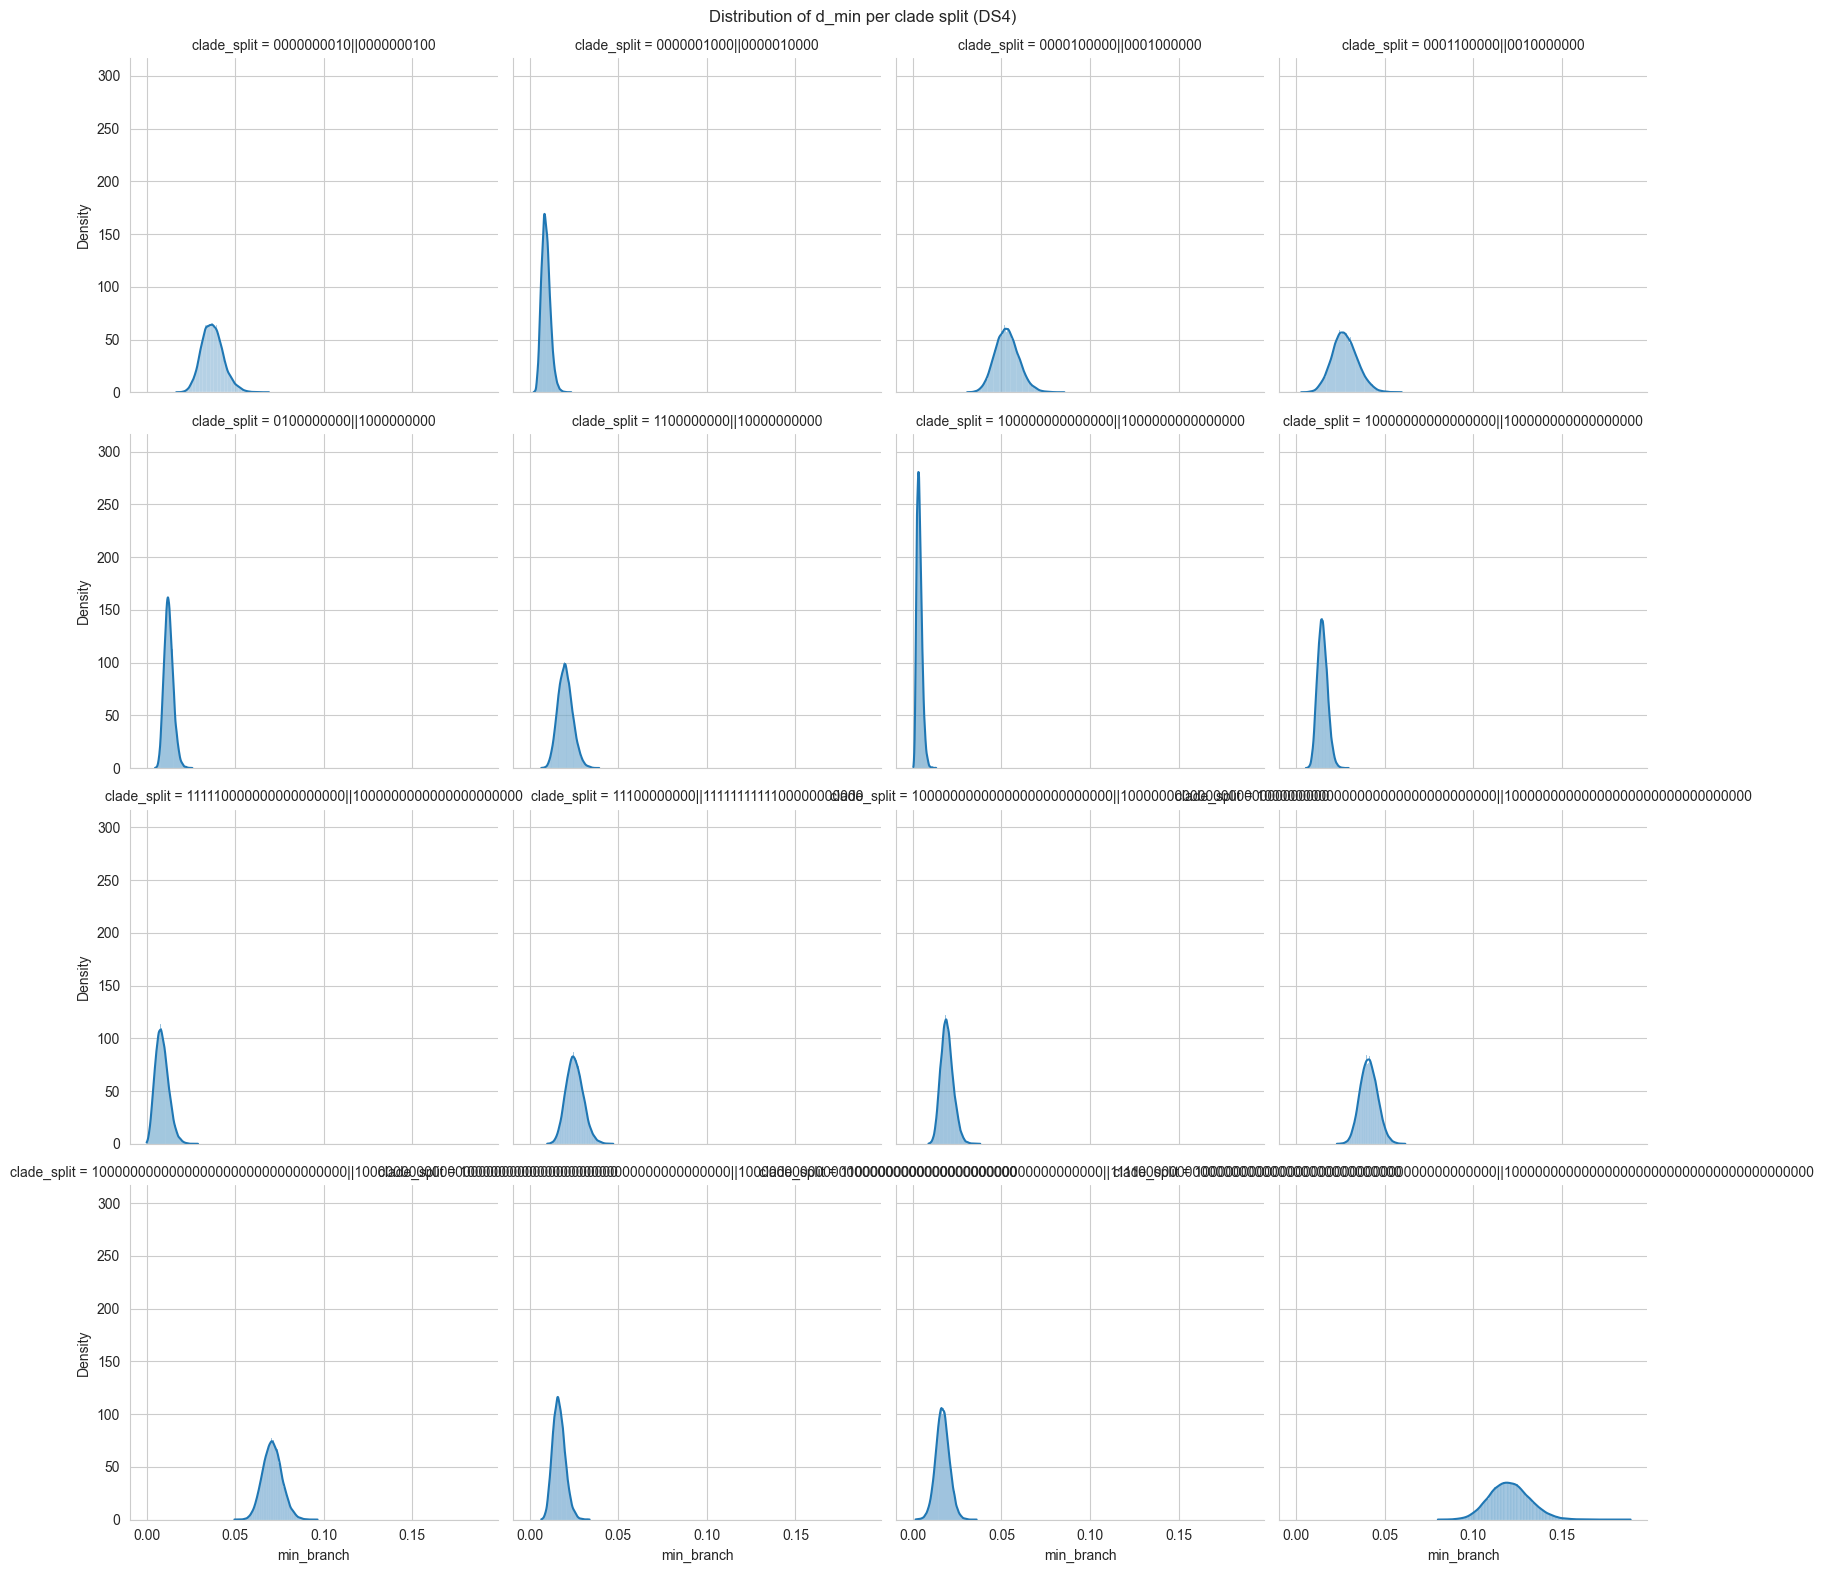

In [55]:
grid = sns.FacetGrid(df_most_common_branches_splits, col="clade_split", col_wrap=4, height=4)
grid.map(sns.histplot, "min_branch", kde=True, stat="density")

grid.figure.subplots_adjust(top=0.95)
grid.figure.suptitle(f"Distribution of d_min per clade split ({DATA_SET_NAME})")